In [11]:
import os
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListSiena
from lib.signals import EegProcessorSiena
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import EogDenoiser, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

### * Scales the EEG signal
### * Select a subset of the channels

{
    "IAS": 33,
    "FBTC": 10,
    "WIAS": 4
}
Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/siena/PN00/PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-06-11 22:51:29,203 - root - INFO - Recording contains channels = ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']


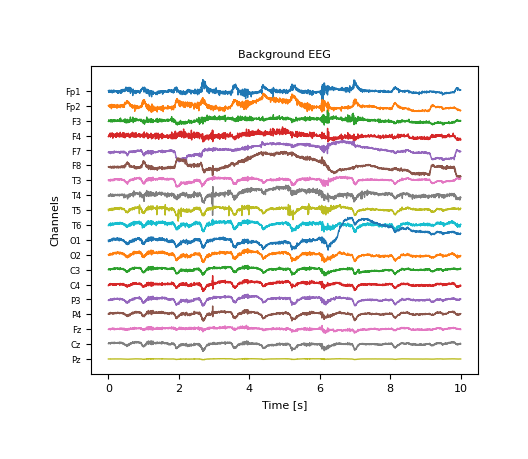

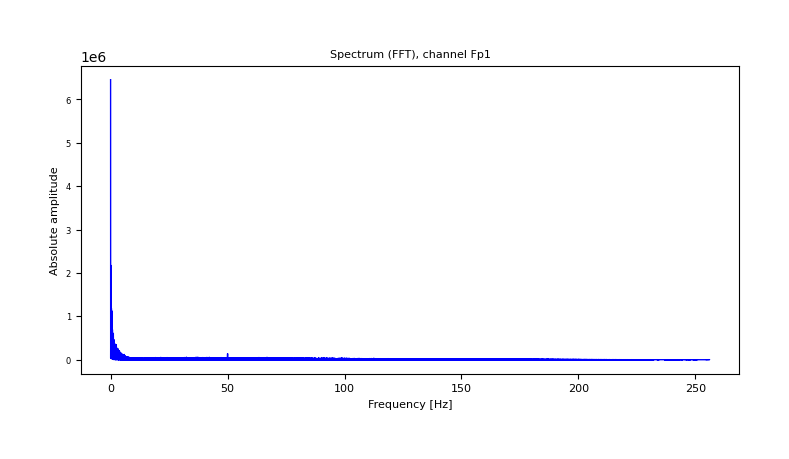

In [12]:
PATIENT = "PN00"
FILENAME = "PN00-1.edf"
PERIOD = [0, 10]

###########################################################
metadata = MetadataListSiena()
metadata.summarize()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorSiena(current_metadata["full_file"])
processor.select_channels()
processor.scale(ekg_reference=True)

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

### * Resample the EEG to 256Hz

2025-06-11 22:51:38,098 - root - INFO - Selected frequency is = 256
2025-06-11 22:51:38,099 - root - INFO - Dowsampling factor is = 2


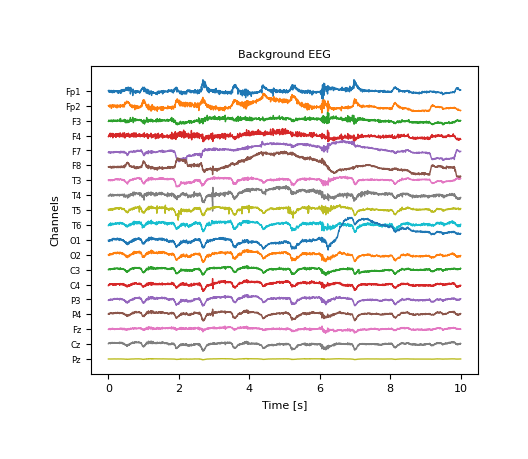

In [13]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Remove the drift noise, high frequency oscillations, power line noise

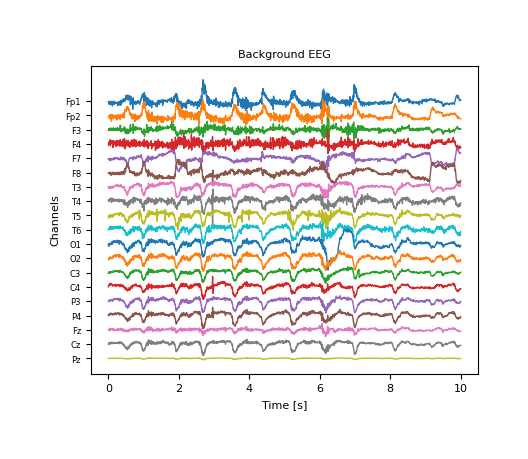

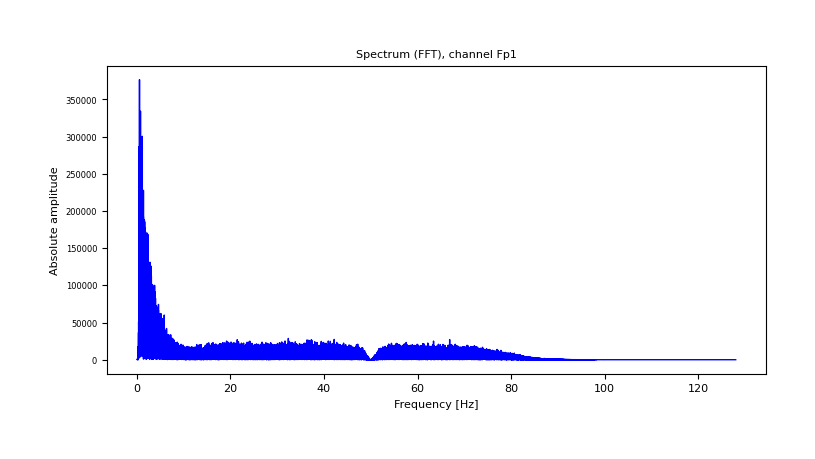

In [14]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

### * Separated sources using iWASOBI

2025-06-11 22:51:50,972 - root - INFO - Number of sources to be removed = 1, indices: [2]
Source = 1, fd = 3.8011818710266483
Source = 2, fd = 4.262925092177136
Source = 3, fd = 4.430874268322526
Source = 4, fd = 4.7310359645273365
Source = 5, fd = 4.982785708611855
Source = 6, fd = 5.3740429398526
Source = 7, fd = 5.443736165351961
Source = 8, fd = 5.474206032059627
Source = 9, fd = 5.495989168242068
Source = 10, fd = 5.518954724191919
Source = 11, fd = 5.8197061229689275
Source = 12, fd = 5.91608254549383
Source = 13, fd = 5.94411093615709
Source = 14, fd = 5.9629385391837095
Source = 15, fd = 5.962957589121597
Source = 16, fd = 6.131203079829369
Source = 17, fd = 6.209606644893448
Source = 18, fd = 6.265760749645093
Source = 19, fd = 6.3109373936673565
Done!


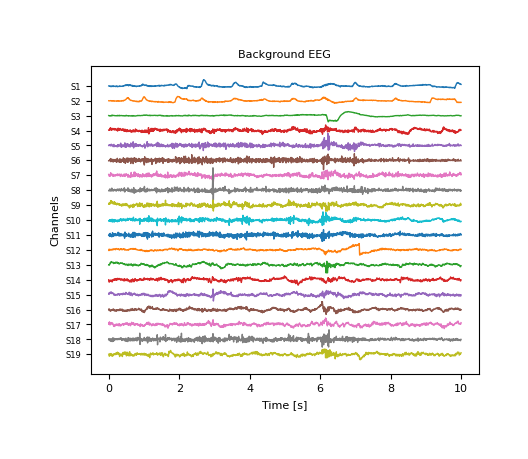

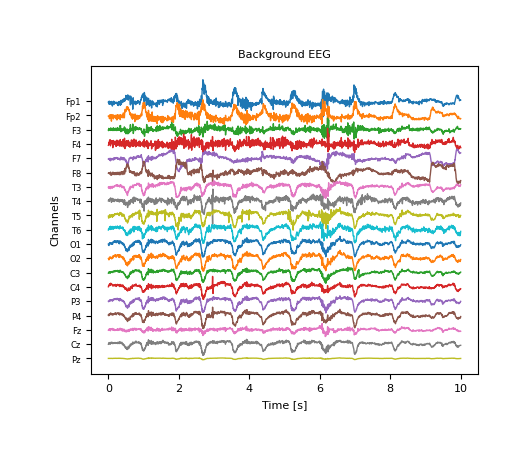

In [15]:
eog_denoiser = EogDenoiser(processor.sampling_frequency)
eeg_sources, clean_eog_eeg = eog_denoiser.apply_by_segments(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                            PERIOD[1]*processor.sampling_frequency])
print(eog_denoiser)

###########################################################
OUTPUT_DIRECTORY = os.getenv("BIOMARKERS_PROJECT_HOME")
output_file_eeg = os.path.join(OUTPUT_DIRECTORY, "images", "siena", "iwasobi_decomposition_example.png")
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10], output_file=output_file_eeg)

###########################################################
plot_eeg_windows(clean_eog_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

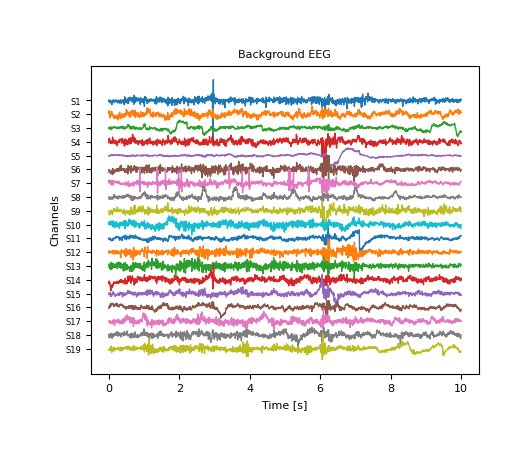

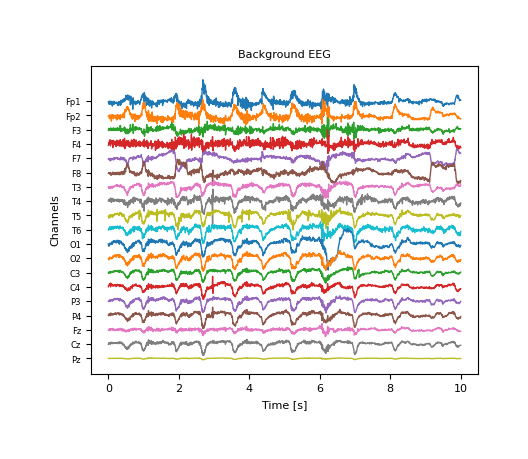

In [16]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

2025-06-11 22:52:18,380 - root - INFO - Number of sources to be removed = 0
Source = 1, fd = 9.397083558150452
Source = 2, fd = 9.533821687503838
Source = 3, fd = 14.338220801654712
Source = 4, fd = 24.149901700585602
Source = 5, fd = 30.529893897324214
Source = 6, fd = 34.958592714538916
Source = 7, fd = 37.741459519631036
Source = 8, fd = 39.15799002520661
Source = 9, fd = 46.7528137928492
Source = 10, fd = 69.14459347409877
Source = 11, fd = 106.7271350340359
Source = 12, fd = 107.81595022272181
Source = 13, fd = 114.65987137432751
Source = 14, fd = 122.1083355247017
Source = 15, fd = 131.93731826592037
Source = 16, fd = 156.42363765277375
Source = 17, fd = 166.4842591085568
Source = 18, fd = 260.32090998967465
Source = 19, fd = 528.6823118740558
Done!


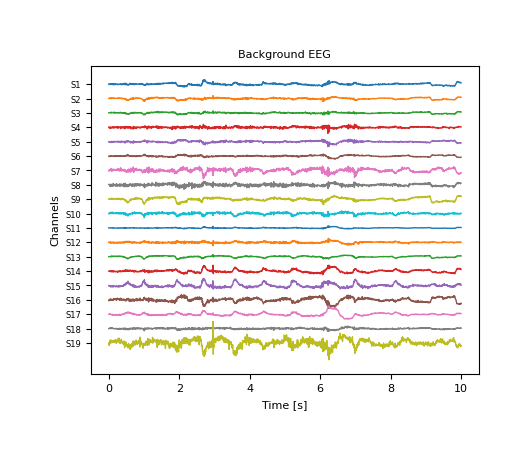

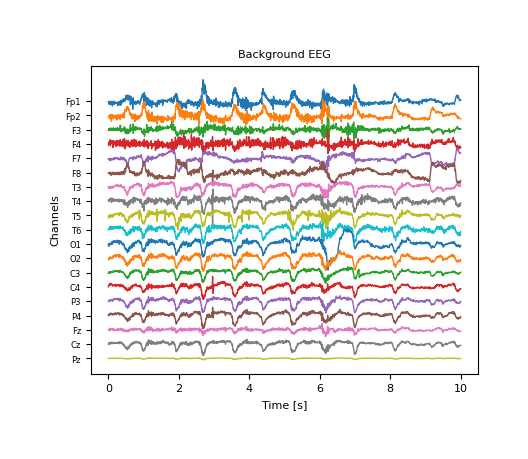

In [19]:
emg_denoiser = EmgDenoiser(processor.sampling_frequency)
eeg_sources, clean_emg_eeg = emg_denoiser.apply_by_segments(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                            PERIOD[1]*processor.sampling_frequency])
print(emg_denoiser)

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
plot_eeg_windows(clean_emg_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Re-referencing to average reference

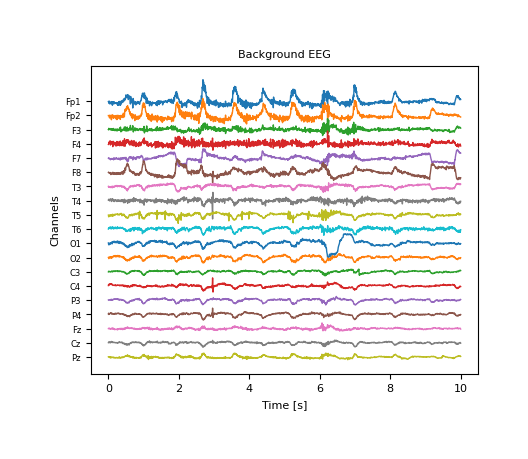

In [20]:
###########################################################
referenced_eeg = processor.rereference_to_average(clean_emg_eeg)

###########################################################
PERIOD = [0, PERIOD[1] - PERIOD[0]]
plot_eeg_windows(referenced_eeg, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Stationarity tests (KPPS and ADF)

In [21]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[0, :2500])

2025-06-11 22:52:49,793 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-06-11 22:52:49,797 - root - INFO - White test, null hyphotesis was rejected, p_value = 9.325297725783781e-20, significance level = 0.05
2025-06-11 22:52:49,800 - root - INFO - The series is trend stationary only (not strict stationarity)


'Trend stationary'